# Is Warren Buffet's Portfolio Choice Optimal?

## 1. Introduction

Warren Buffet is the world's most prominent value investor. We decided to analyze his portfolio to see if there were any improvements to be made. We loosely make use of the work of:
- Michael Pinelis and David Ruppert (Machine learning portfolio allocation(2021))
-  Shihao Gu, Bryan Kelly, and Dacheng Xiu (Empirical Asset Pricing via Machine
 Learning(2019))

In [39]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import base64
from IPython.display import Image, display
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from xgboost import XGBRegressor
from pypfopt import risk_models, expected_returns, plotting
from pypfopt.efficient_frontier import EfficientFrontier
from sklearn.feature_selection import SelectKBest, f_regression

In [40]:
BuffetPortfolioOverview = pd.read_csv("Warren Buffet Portfolio Overview.csv")
BuffetPortfolioOverview

,Company,Ticker,"Market value as of 31 March, 2024",Number of shares,% of total portfolio
0,APPLE INC (COM),AAPL,"135,360,902,000","789,368,450",40.81%
1,BANK OF AMERICA CORP (COM),BAC,"39,165,748,000","1,032,852,006",11.81%
2,AMERICAN EXPRESS CO (COM),AXP,"34,520,240,000","151,610,700",10.41%
3,COCA COLA CO (COM),KO,"24,472,000,000","400,000,000",7.38%
4,CHEVRON CORP (COM),CVX,"19,398,898,000","122,980,207",5.85%
5,OCCIDENTAL PETROLEUM (COM),OXY,"16,118,698,000","248,018,128",4.86%
6,KRAFT HEINZ CO (COM),KHC,"12,015,925,000","325,634,818",3.62%
7,MOODYS CORP (COM),MCO,"9,695,962,000","24,669,778",2.92%
8,CHUBB LIMITED (COM),CB,"6,717,645,000","25,923,840",2.03%
9,DAVITA HEALTHCARE PARTNERS (COM),DVA,"4,982,993,000","36,095,570",1.50%


## 2. Research Method

The image below provides an overview of how we plan to proceed with our analysis.

In [41]:
def mm(graph):
    graphbytes = graph.encode("utf8")
    base64_bytes = base64.b64encode(graphbytes)
    base64_string = base64_bytes.decode("ascii")
    display(Image(url="https://mermaid.ink/img/" + base64_string))

mm("""
graph TD
    subgraph "Data Processing"
        A[Raw Data] --> B[Missing Value Imputation]
        B --> C[Normalization]
    end

    subgraph "Feature Engineering"
        D[Features] --> E[Fundamental Features]
        D --> F[Technical Features]
        D --> G[Sentiment Features]
    end
    
    E --> H[RF Model Training]
    F --> H
    G --> H
		
    subgraph "Training"
        H[RF Model Training] --> I[Hyperparameter Optimization]
        I --> J[Optimal Model]
    end

    subgraph "Prediction"
        K[Test Data] --> L[Return Ratio Prediction]
    end

    subgraph "Investment Strategy"
        M[Investment Strategy] --> N[Stock Selection]
        N --> O[Investment Portfolio Return & Std]
    end

    subgraph "Evaluation"
        P[Evaluation Method] --> Q[Sharpe Ratio]
    end

    C --> D
    J --> L
    L --> N
    O --> Q
""")

## 3. Data Processing

In [42]:
financial_ratios = pd.read_csv("2014-2024 Buffet Portfolio - financial ratios.csv")
financial_ratios.describe()

,gvkey,permno,CAPEI,bm,evm,pe_op_basic,pe_op_dil,pe_exi,pe_inc,ps,...,pay_turn,sale_invcap,sale_equity,sale_nwc,rd_sale,adv_sale,staff_sale,accrual,ptb,PEG_trailing
count,4711.000000,4711.000000,4642.000000,4397.000000,4701.000000,4640.000000,4640.000000,4640.000000,4640.000000,4701.000000,...,4521.000000,4696.000000,4375.000000,2479.000000,4701.000000,4701.000000,4701.000000,4680.000000,4397.000000,3051.000000
mean,40526.249629,52176.914031,29.878632,0.603942,12.443296,12.870193,13.309260,16.051649,17.033933,3.696466,...,8.888087,1.292531,3.418766,14.165560,0.015078,0.020006,0.071173,-0.041818,5.523823,1.640502
std,58402.993987,29634.292265,137.151234,0.508289,127.622422,53.446141,53.375605,82.607543,82.795749,6.762963,...,12.296629,2.200181,9.041726,43.464448,0.044623,0.028905,0.124070,0.058970,9.266644,5.971164
min,1447.000000,11308.000000,-2615.300000,0.003000,-4544.900000,-714.520000,-714.520000,-2125.000000,-2125.000000,0.062000,...,-0.233000,0.113000,0.120000,-172.250000,0.000000,0.000000,0.000000,-0.267000,0.222000,-77.522000
25%,6239.000000,16678.000000,11.699750,0.199000,9.098000,9.100500,9.259250,8.402750,8.348750,1.190000,...,1.741000,0.383000,0.672500,2.986500,0.000000,0.000000,0.000000,-0.071000,1.076000,0.188000
50%,12459.000000,56223.000000,20.942000,0.466000,12.573000,15.622500,15.936000,16.173500,15.949500,1.888000,...,4.070000,0.715000,1.396000,6.415000,0.000000,0.006000,0.000000,-0.036000,2.175000,0.616000
75%,61483.000000,81055.000000,35.358500,0.928000,17.987000,24.894000,25.753750,27.509250,27.724250,3.906000,...,10.905000,1.235250,2.573000,12.497000,0.004000,0.032000,0.148000,-0.012000,5.232000,1.449000
max,339965.000000,92611.000000,1447.000000,3.614000,1223.880000,478.000000,490.500000,758.328000,774.000000,126.556000,...,77.108000,44.562000,152.413000,977.032000,0.465000,0.204000,0.905000,0.757000,64.657000,63.498000


In [43]:
stock = pd.read_csv("2014-2024 Buffet Portfolio - stock.csv")
stock.describe()

/tmp/ipykernel_89764/244833115.py:1: DtypeWarning: Columns (5,9,22,49,57) have mixed types. Specify dtype option on import or set low_memory=False.
  stock = pd.read_csv("2014-2024 Buffet Portfolio - stock.csv")


,PERMNO,SHRCD,EXCHCD,NAICS,PERMCO,ISSUNO,HEXCD,HSICCD,DLAMT,DLSTCD,...,SHROUT,CFACPR,CFACSHR,OPENPRC,NUMTRD,vwretd,vwretx,ewretd,ewretx,sprtrn
count,89589.000000,89589.000000,89589.000000,89563.000000,89589.000000,89589.000000,89589.000000,89589.000000,44.000000,44.000000,...,8.958300e+04,89583.000000,89583.000000,89583.000000,2.639500e+04,89589.000000,89589.000000,89589.000000,89589.000000,89589.000000
mean,49773.033832,15.129893,1.757973,464534.521733,29650.113954,16938.273159,1.801505,5891.083269,6.538636,115.250000,...,1.314680e+06,1.576633,1.546429,227.541278,7.267247e+04,0.000449,0.000371,0.000343,0.000261,0.000439
std,30343.528813,14.497378,1.053536,110869.404027,17500.224502,29921.136917,1.062598,2302.737062,23.420962,43.099736,...,2.443694e+06,3.051686,3.055253,635.758014,1.557989e+05,0.011025,0.011024,0.010709,0.010710,0.011170
min,11308.000000,11.000000,1.000000,211111.000000,7.000000,0.000000,1.000000,1311.000000,0.000000,100.000000,...,3.179000e+03,0.904200,0.250000,3.050000,0.000000e+00,-0.118168,-0.118218,-0.107631,-0.107768,-0.119841
25%,15998.000000,11.000000,1.000000,423990.000000,20440.000000,0.000000,1.000000,4832.000000,0.000000,100.000000,...,1.845000e+05,1.000000,1.000000,37.475000,7.672000e+03,-0.003923,-0.003978,-0.004576,-0.004659,-0.003812
50%,56223.000000,11.000000,1.000000,517210.000000,21299.000000,0.000000,1.000000,6029.000000,0.000000,100.000000,...,4.387400e+05,1.000000,1.000000,76.660000,2.055000e+04,0.000668,0.000550,0.000709,0.000623,0.000597
75%,80924.000000,11.000000,3.000000,524130.000000,50700.000000,20733.000000,3.000000,7370.000000,0.000000,100.000000,...,1.045085e+06,1.000000,1.000000,163.519995,5.295650e+04,0.005631,0.005565,0.005748,0.005679,0.005690
max,92611.000000,73.000000,4.000000,721110.000000,59045.000000,89707.000000,4.000000,9999.000000,128.769990,241.000000,...,1.710254e+07,28.000000,28.000000,7028.500000,2.970000e+06,0.091556,0.091477,0.082175,0.082032,0.093828


Merged data was created with the combination of the financial ratios, stock ratios and a few macroeconomic predictors as indicated by Gu et al. Here we simply present the cleaned data as the merge process was lengthy, and laborious.

In [44]:
merged_data = pd.read_csv("merged_financial_stock_macro_data.csv")
merged_data = merged_data.drop(merged_data.columns[0], axis=1)
merged_data.head()

,TICKER,date,CAPEI,bm,evm,pe_op_basic,pe_op_dil,pe_exi,pe_inc,ps,...,TICKER_encoded,SHRCD_encoded,EXCHCD_encoded,SICCD_encoded,market_cap,RET_calc,RET_interp,TB3MS,T10Y2Y,BAA10Y
0,AAPL,2014-01-31,17.588,0.327,7.993,12.506,12.594,12.594,12.594,2.613,...,0.0,0.0,1.0,10.0,4.465297e+08,0.001637,0.001637,0.04,2.464286,2.334762
1,AAPL,2014-02-28,18.776,0.296,7.764,0.463,0.466,0.466,0.466,2.698,...,0.0,0.0,1.0,10.0,4.694003e+08,-0.002710,-0.002710,0.05,2.382632,2.390000
2,AAPL,2014-03-31,18.501,0.296,7.764,0.472,0.475,0.475,0.475,2.658,...,0.0,0.0,1.0,10.0,4.625330e+08,-0.000224,-0.000224,0.05,2.324286,2.340952
3,AAPL,2014-04-30,20.332,0.296,7.764,0.519,0.523,0.523,0.523,2.921,...,0.0,0.0,1.0,10.0,5.082923e+08,-0.003782,-0.003782,0.03,2.288095,2.199048
4,AAPL,2014-05-31,20.513,0.302,7.873,0.537,0.540,0.540,0.540,3.097,...,0.0,0.0,1.0,10.0,5.452542e+08,-0.003746,-0.003746,0.03,2.170000,2.203810


# 4. Descriptive Analysis

In this section we explore various features of our data set. We can see that price is highly variable over time. In the correlation matrix we see that the price ratios related to shareholder dividends, income and operating expenses were the most highly correlated. For the most part, stock market returns were 0 and most companies had a negligible market size.

/home/onlyartist9/miniconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/onlyartist9/miniconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


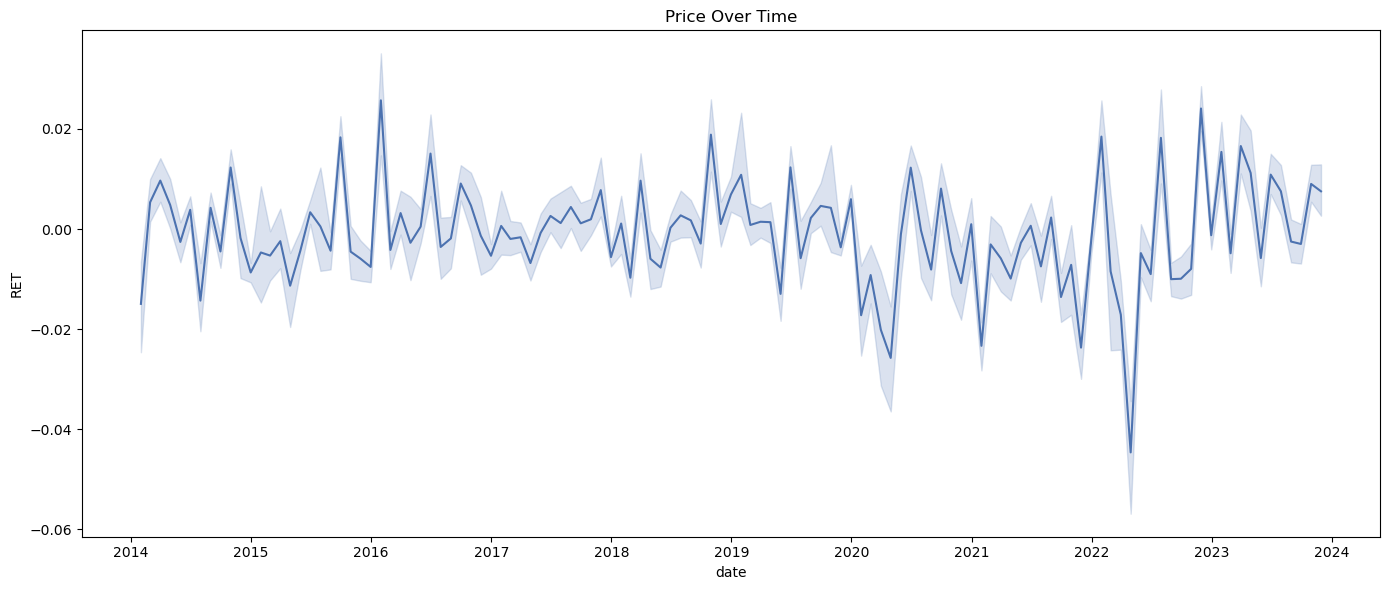

In [45]:
merged_data['date'] = pd.to_datetime(merged_data['date'])

# Basic statistical description
statistical_description = merged_data.describe()

# Plotting the trends of a few selected metrics over time
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(14, 6))

# Plotting RET
sns.lineplot(x='date', y='RET', data=merged_data).set_title('Price Over Time')

plt.tight_layout()
plt.show()

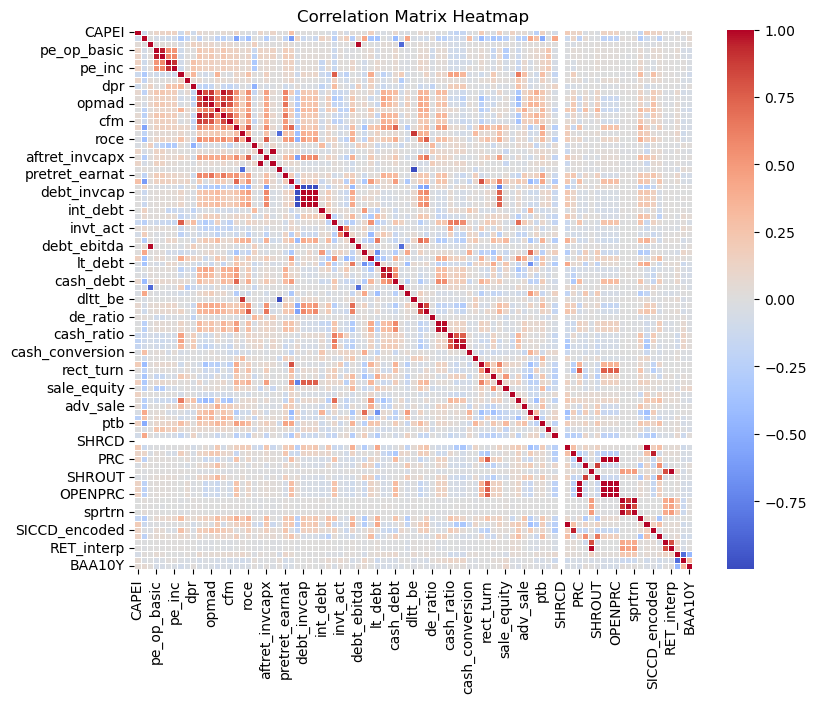

<Figure size 640x480 with 0 Axes>

In [46]:
# Recalculate the correlation matrix
correlation_matrix = merged_data.select_dtypes(include=['number']).drop(columns = 'SHRCD_encoded').corr()

# Set up the matplotlib figure
plt.figure(figsize=(9, 7))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, annot=False, fmt=".1f", linewidths=.5, cmap="coolwarm")
plt.title('Correlation Matrix Heatmap')
plt.show()
plt.savefig('Correlation_matrix_heatmap.png')


/tmp/ipykernel_89764/980479959.py:12: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  numeric_data.hist(layout=(-1, 3), bins=np.linspace(-1,1,50), ax=ax)


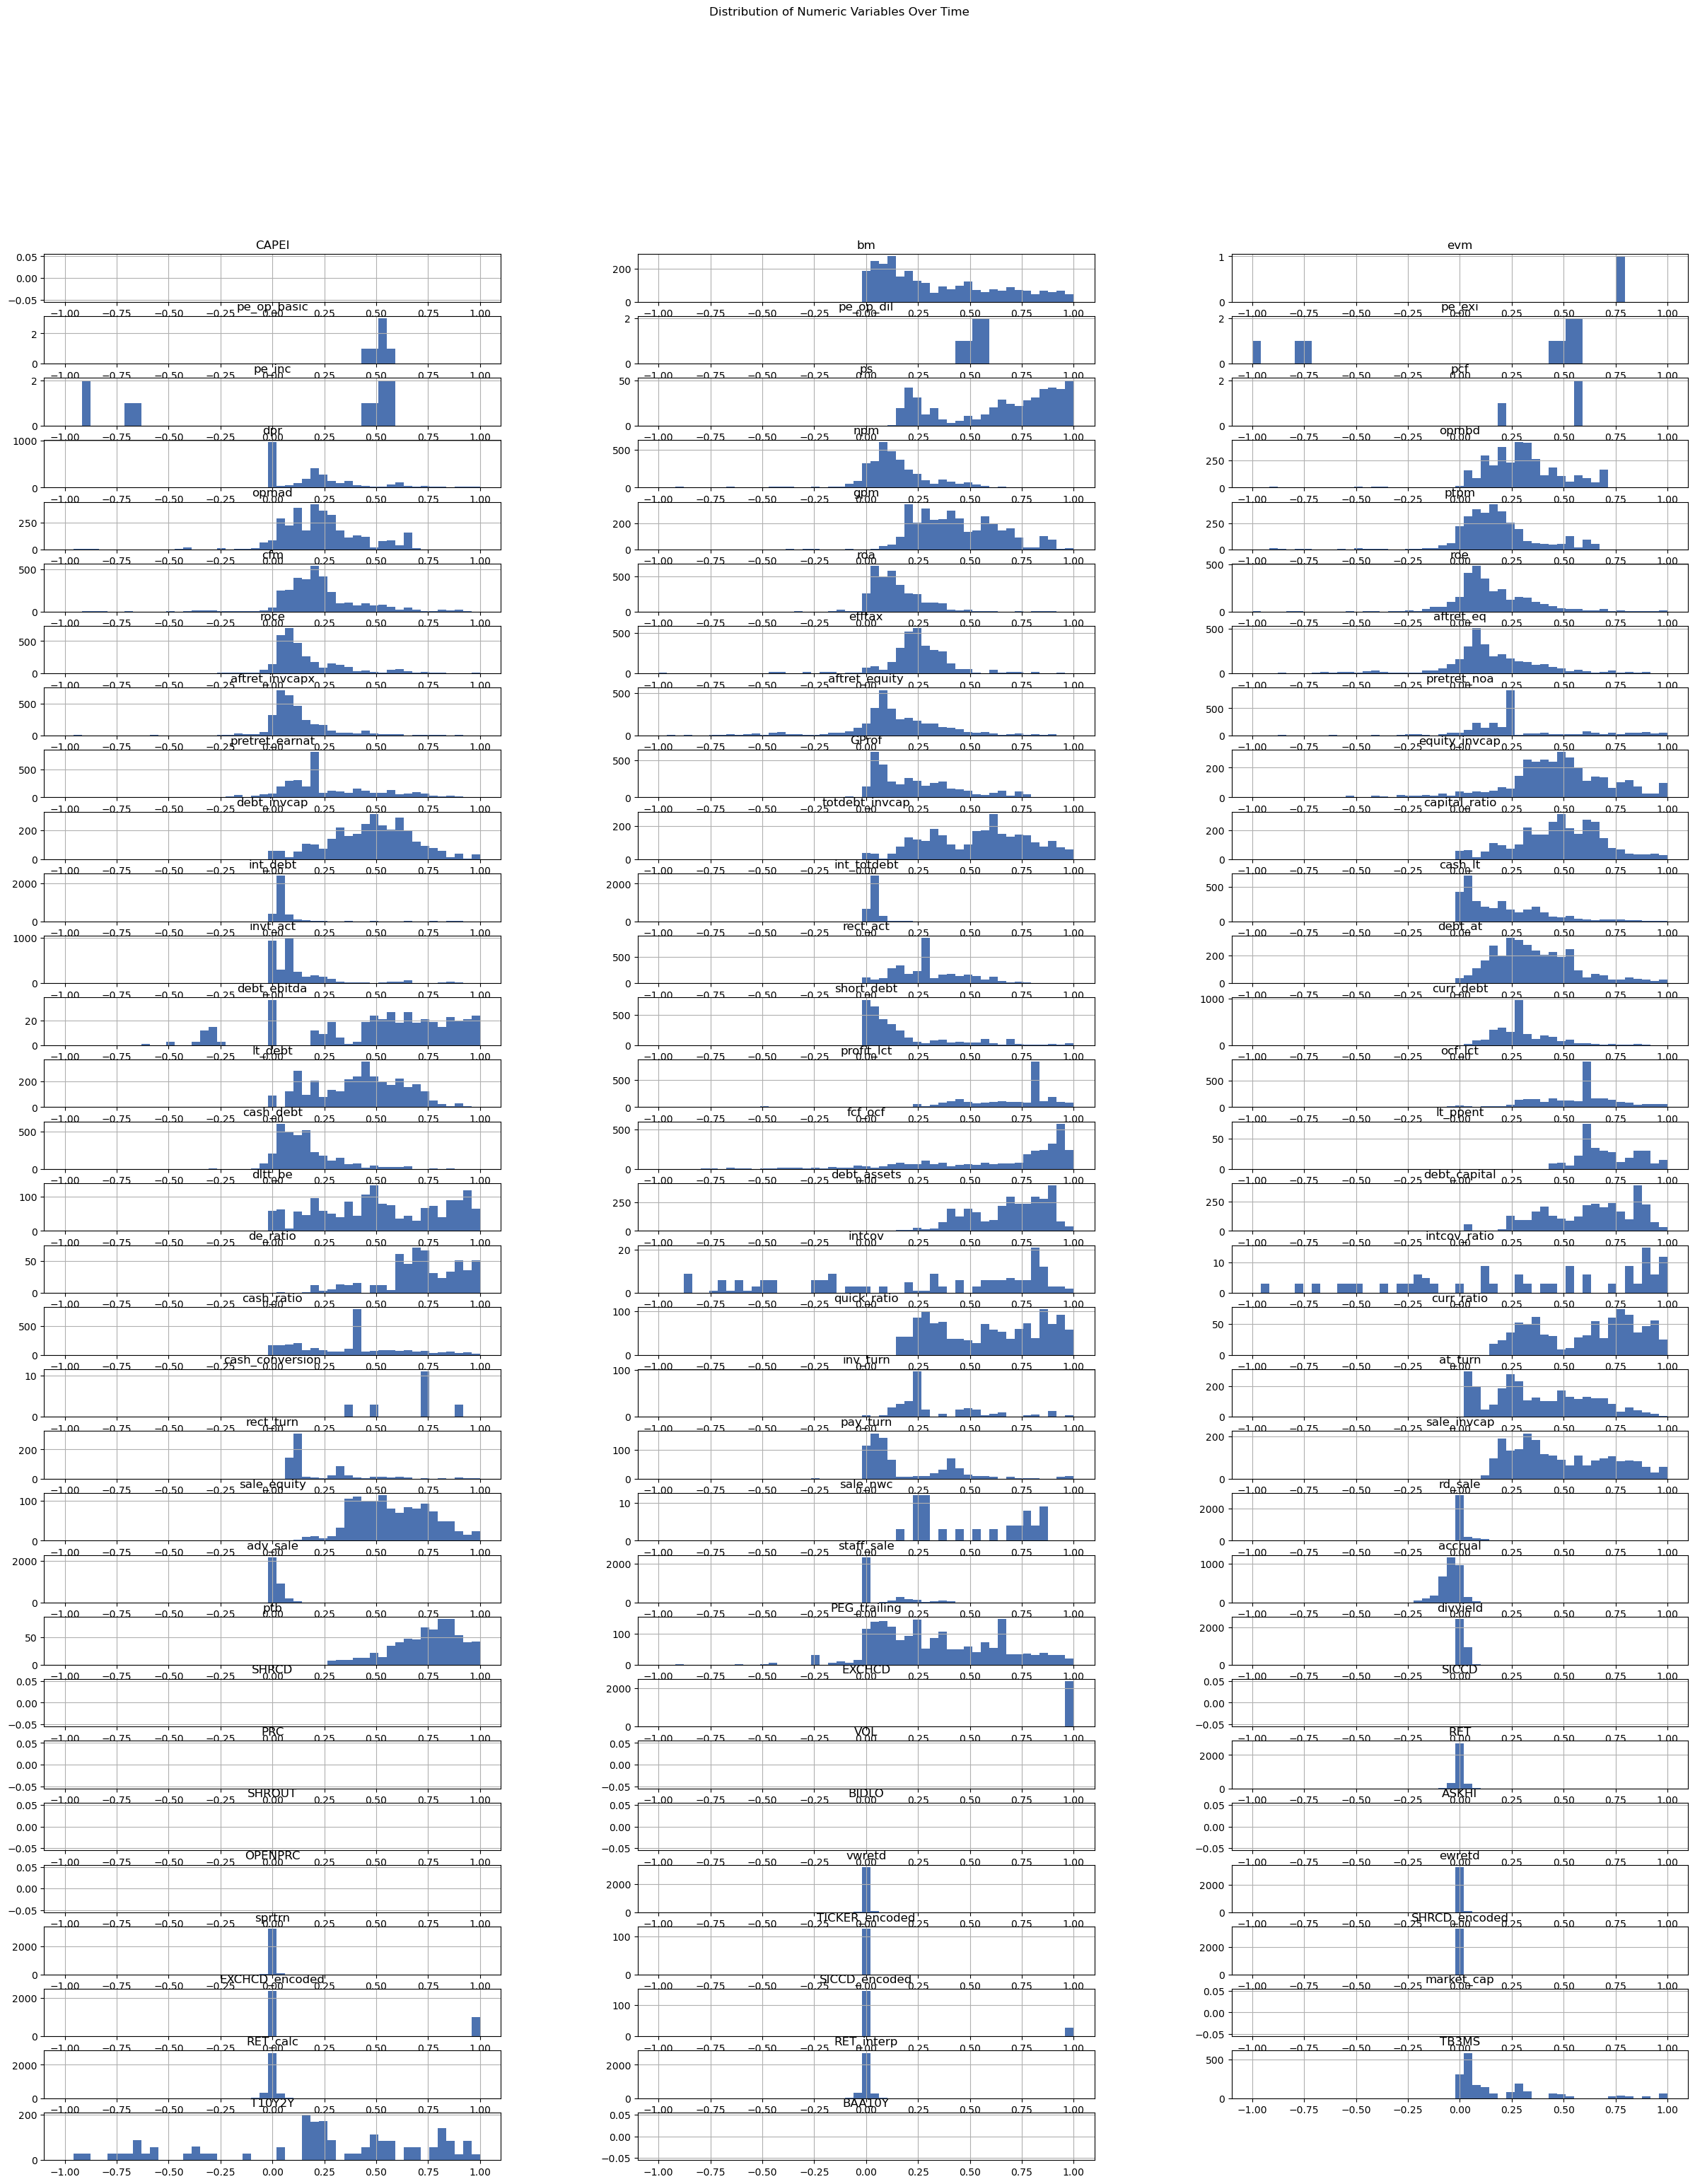

In [47]:
# Filter out non-numeric columns from merged_data
numeric_data = merged_data.select_dtypes(include=[np.number])

# Create a figure and axis object
fig, ax = plt.subplots()

# Set the figure height and width
fig.set_figheight(35)
fig.set_figwidth(30)

# Plot histograms for the numeric columns in numeric_data
numeric_data.hist(layout=(-1, 3), bins=np.linspace(-1,1,50), ax=ax)

# Set the title for the figure
fig.suptitle('Distribution of Numeric Variables Over Time')

# Save the figure as 'numbers_over_time.png'
plt.savefig('Distribution_of_Numeric_Variables_Over_Time.png')

/home/onlyartist9/miniconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


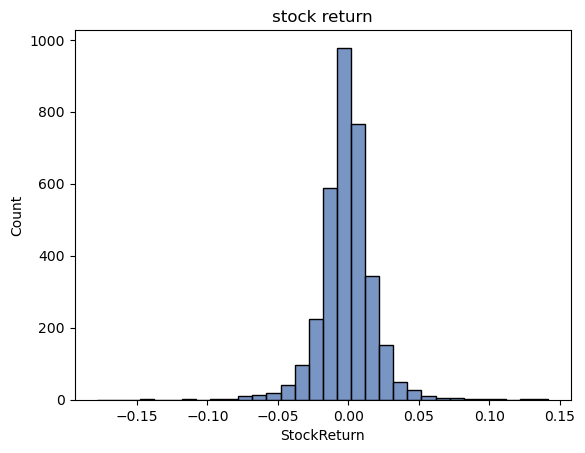

In [48]:
df_3 = merged_data[["RET"]]
df_3 = df_3.rename(columns={'RET': 'StockReturn'})
sns.histplot(data = df_3, x ="StockReturn", binwidth = 0.01, binrange = (df_3["StockReturn"].min()+ 0.00000000001, df_3["StockReturn"].max()- 0.01))
plt.title('stock return')
plt.show()

/home/onlyartist9/miniconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


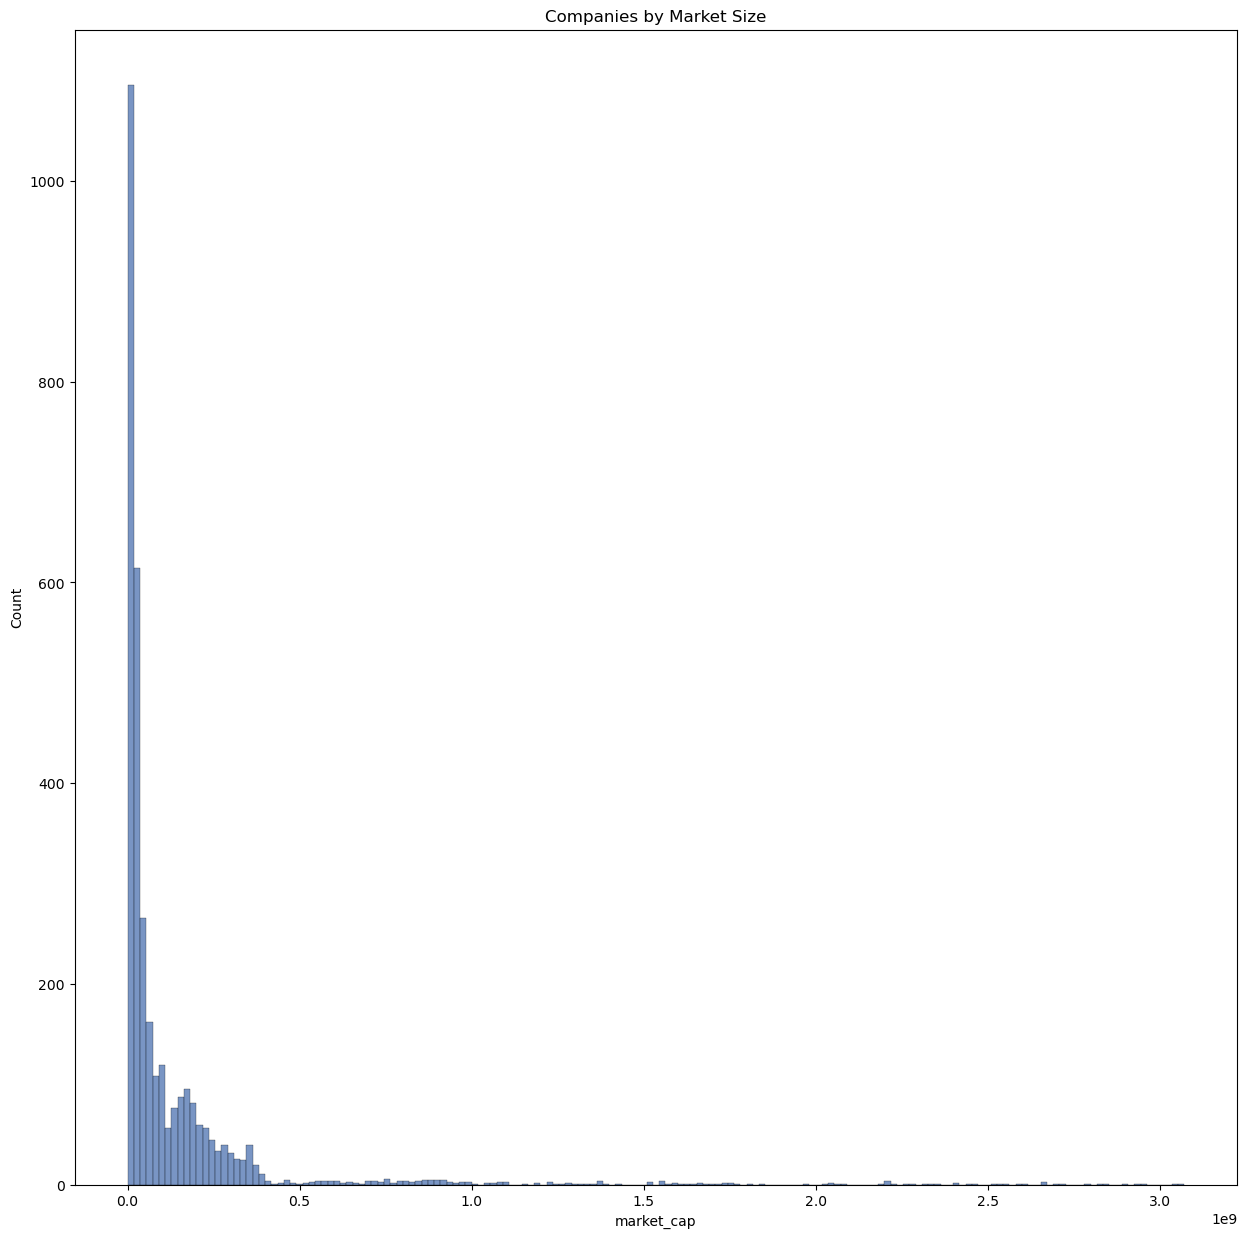

In [49]:
# Set the global size of the figure
fig, ax = plt.subplots()

# Calculate the maximum market capitalization
max_size = merged_data['market_cap'].max()

# Plot the histogram
ax = sns.histplot(data=merged_data, x="market_cap", binrange=(0, max_size))
ax.set_title('Companies by Market Size')  # Set the title

# Define the image size
fig.set_figheight(15)
fig.set_figwidth(15)

# Show the figure
plt.show()

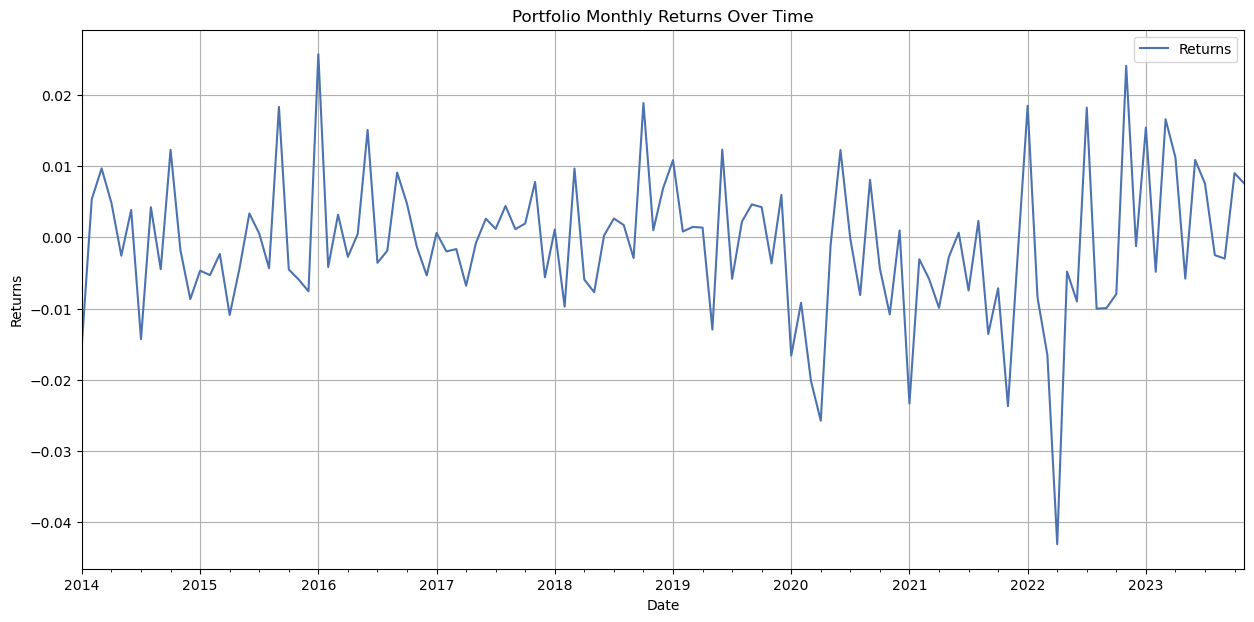

In [50]:
# Assuming final_data is defined
ret_data = merged_data[["RET", "TICKER", "date"]].copy()  # Create a copy to work on to avoid affecting original data

# Create equal weights safely using loc
ret_data['eq_weights'] = 1 / ret_data.groupby('date')['TICKER'].transform('size')

# Calculate monthly return of the equally weighted portfolio containing all stocks
# Use loc to ensure the operation is directly on the DataFrame
ret_data.loc[:, 'return_stock_ew'] = ret_data['RET'].astype(float) * ret_data['eq_weights']

# Calculate the total returns for each date
ret_data.loc[:, 'Returns'] = ret_data.groupby('date')['return_stock_ew'].transform('sum')

# Drop duplicates and set index
unique_ret_data = ret_data[['date', 'Returns']].drop_duplicates().set_index('date')

# Plot the portfolio returns over time
unique_ret_data.plot(grid=True, figsize=(15, 7))
plt.title('Portfolio Monthly Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.grid(True)

# Save the graph
plt.show()

# Feature Engineering

Out feature engineering was simplistic. We divided our data into features for use and returns. The features in our feature engineered data set are many.

In [51]:
merged_data.columns

Index(['TICKER', 'date', 'CAPEI', 'bm', 'evm', 'pe_op_basic', 'pe_op_dil',
       'pe_exi', 'pe_inc', 'ps', 'pcf', 'dpr', 'npm', 'opmbd', 'opmad', 'gpm',
       'ptpm', 'cfm', 'roa', 'roe', 'roce', 'efftax', 'aftret_eq',
       'aftret_invcapx', 'aftret_equity', 'pretret_noa', 'pretret_earnat',
       'GProf', 'equity_invcap', 'debt_invcap', 'totdebt_invcap',
       'capital_ratio', 'int_debt', 'int_totdebt', 'cash_lt', 'invt_act',
       'rect_act', 'debt_at', 'debt_ebitda', 'short_debt', 'curr_debt',
       'lt_debt', 'profit_lct', 'ocf_lct', 'cash_debt', 'fcf_ocf', 'lt_ppent',
       'dltt_be', 'debt_assets', 'debt_capital', 'de_ratio', 'intcov',
       'intcov_ratio', 'cash_ratio', 'quick_ratio', 'curr_ratio',
       'cash_conversion', 'inv_turn', 'at_turn', 'rect_turn', 'pay_turn',
       'sale_invcap', 'sale_equity', 'sale_nwc', 'rd_sale', 'adv_sale',
       'staff_sale', 'accrual', 'ptb', 'PEG_trailing', 'divyield', 'COMNAM',
       'SHRCD', 'EXCHCD', 'SICCD', 'PRC', 'VOL', 'RET

In [52]:
# Assuming merged_data is already loaded and contains your data
merged_data['date'] = pd.to_datetime(merged_data['date'])
merged_data.sort_values('date', inplace=True)

# Prepare the data
features = merged_data[['CAPEI', 'bm', 'evm', 'pe_op_basic', 'pe_op_dil', 'pe_exi', 'pe_inc', 'ps', 'pcf', 'dpr', 'npm', 'opmbd', 'opmad', 'gpm', 'ptpm', 'cfm', 'roa', 'roe', 'roce', 'efftax', 'aftret_eq', 'aftret_invcapx', 'aftret_equity', 'pretret_noa', 'pretret_earnat', 'GProf', 'equity_invcap', 'debt_invcap', 'totdebt_invcap', 'capital_ratio', 'int_debt', 'int_totdebt', 'cash_lt', 'invt_act', 'rect_act', 'debt_at', 'debt_ebitda', 'short_debt', 'curr_debt', 'lt_debt', 'profit_lct', 'ocf_lct', 'cash_debt', 'fcf_ocf', 'lt_ppent', 'dltt_be', 'debt_assets', 'debt_capital', 'de_ratio', 'intcov', 'intcov_ratio', 'cash_ratio', 'quick_ratio', 'curr_ratio', 'cash_conversion', 'inv_turn', 'at_turn', 'rect_turn', 'pay_turn', 'sale_invcap', 'sale_equity', 'sale_nwc', 'rd_sale', 'adv_sale', 'staff_sale', 'accrual', 'ptb', 'PEG_trailing', 'divyield']]
target = merged_data['RET']

# Data Preprocessing

Here we select the 10 most important features that help us build a more robust model.

In [53]:
# Remove nulls and infinite values
merged_data.replace([np.inf, -np.inf], np.nan, inplace=True)
merged_data.dropna(subset=features.columns.tolist() + ['RET'], inplace=True)

# Prepare the data
features = merged_data[['CAPEI', 'bm', 'evm', 'pe_op_basic', 'pe_op_dil', 'pe_exi', 'pe_inc', 'ps', 'pcf', 'dpr', 'npm', 'opmbd', 'opmad', 'gpm', 'ptpm', 'cfm', 'roa', 'roe', 'roce', 'efftax', 'aftret_eq', 'aftret_invcapx', 'aftret_equity', 'pretret_noa', 'pretret_earnat', 'GProf', 'equity_invcap', 'debt_invcap', 'totdebt_invcap', 'capital_ratio', 'int_debt', 'int_totdebt', 'cash_lt', 'invt_act', 'rect_act', 'debt_at', 'debt_ebitda', 'short_debt', 'curr_debt', 'lt_debt', 'profit_lct', 'ocf_lct', 'cash_debt', 'fcf_ocf', 'lt_ppent', 'dltt_be', 'debt_assets', 'debt_capital', 'de_ratio', 'intcov', 'intcov_ratio', 'cash_ratio', 'quick_ratio', 'curr_ratio', 'cash_conversion', 'inv_turn', 'at_turn', 'rect_turn', 'pay_turn', 'sale_invcap', 'sale_equity', 'sale_nwc', 'rd_sale', 'adv_sale', 'staff_sale', 'accrual', 'ptb', 'PEG_trailing', 'divyield']]
target = merged_data['RET']

# Feature Selection
selector = SelectKBest(score_func=f_regression, k=20)  # Select top 20 features
selector.fit(features, target)
selected_features = features.columns[selector.get_support()]

print("Selected features:")
print(selected_features)

# Use selected features for training and testing
features = merged_data[selected_features]


Selected features:
Index(['npm', 'opmad', 'ptpm', 'cfm', 'roe', 'pretret_noa', 'debt_at',
       'lt_debt', 'profit_lct', 'lt_ppent', 'dltt_be', 'intcov',
       'intcov_ratio', 'curr_ratio', 'pay_turn', 'sale_nwc', 'rd_sale',
       'staff_sale', 'accrual', 'divyield'],
      dtype='object')


# Predictive Analysis

Based on the work of Gu et al. Random Forests and Gradient Boosted trees perform the best for predictive analysis. We make use of TimeSeriesSplit to split our data hyperparameter tune our models for each iteration of predictions and plot our data across time. Our R2 here is terrible but the Mean Squared Error seems reasonable given the data.

Random Forest R²: -0.07704785879062692, MSE: 0.0003059612364753519
XGBoost R²: -0.015294003964370306, MSE: 0.00028841857518546596


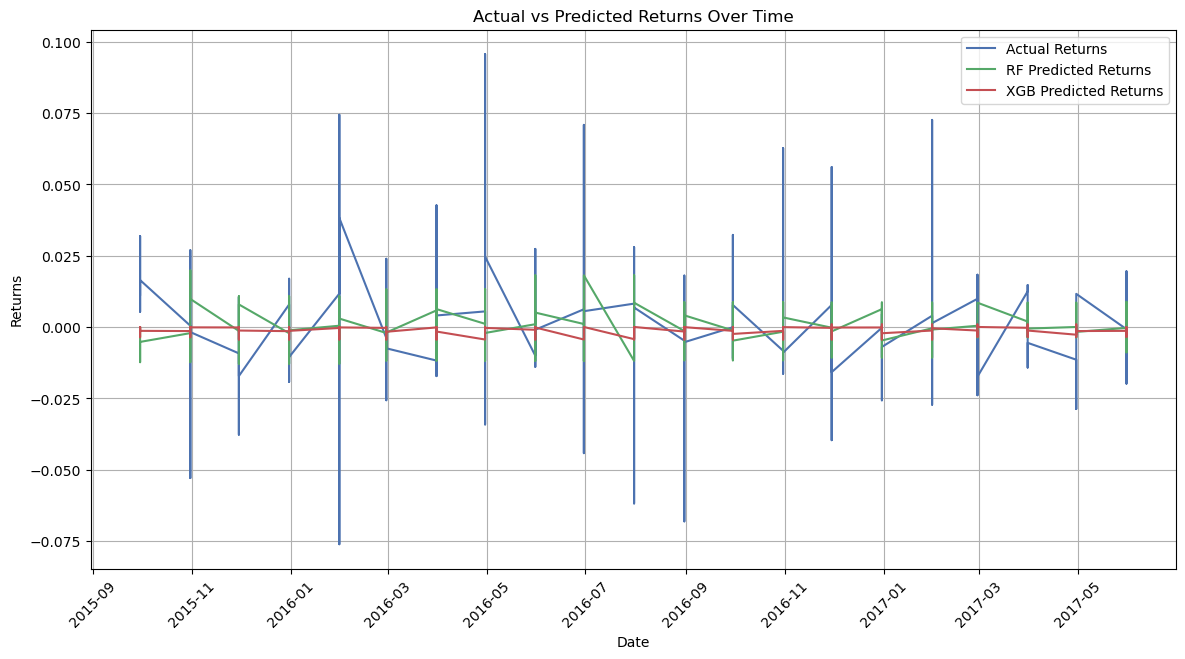

Random Forest R²: -0.08154483660709033, MSE: 0.00026190294256017845
XGBoost R²: -0.031330965232563956, MSE: 0.000249743335093896


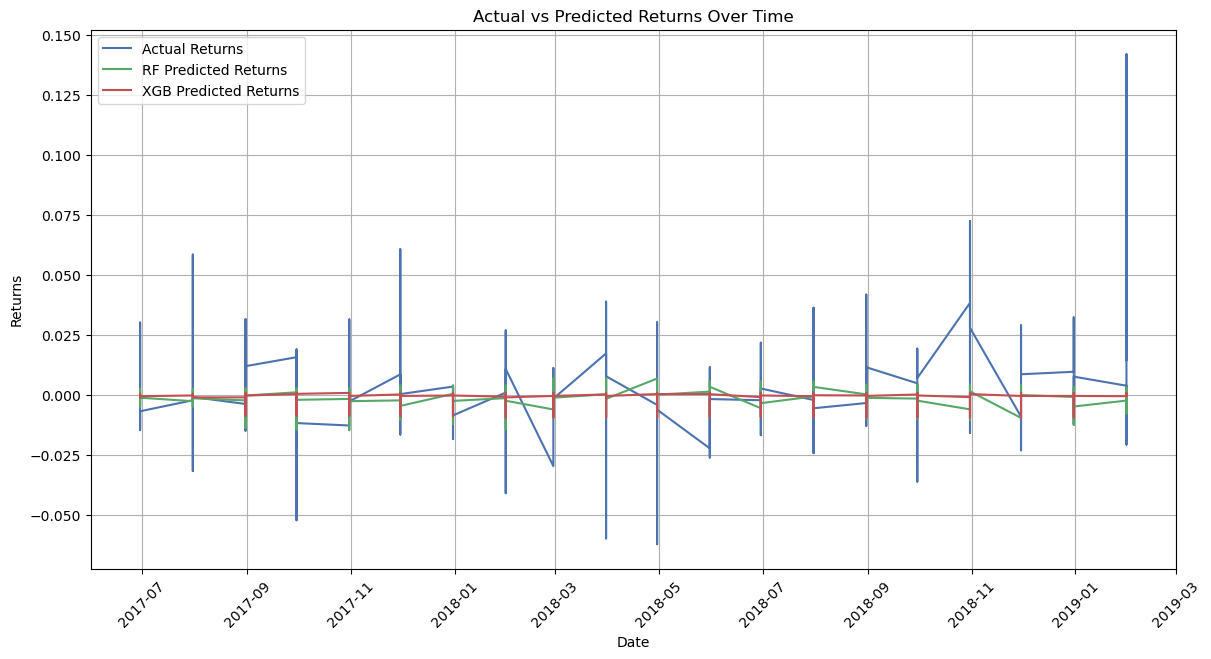

Random Forest R²: -0.04684796520658363, MSE: 0.0004586964989827174
XGBoost R²: -0.01981094832360908, MSE: 0.0004468497118662045


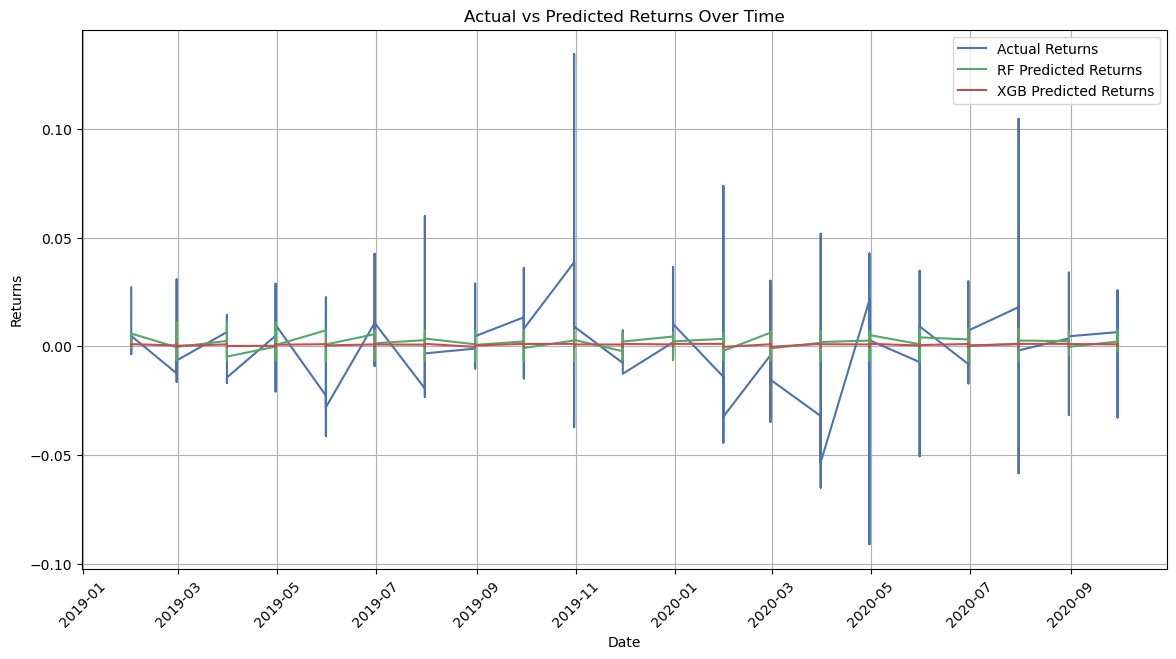

Random Forest R²: -0.23483187555939922, MSE: 0.000672476394324268
XGBoost R²: -0.11376988606332428, MSE: 0.0006065473137770378


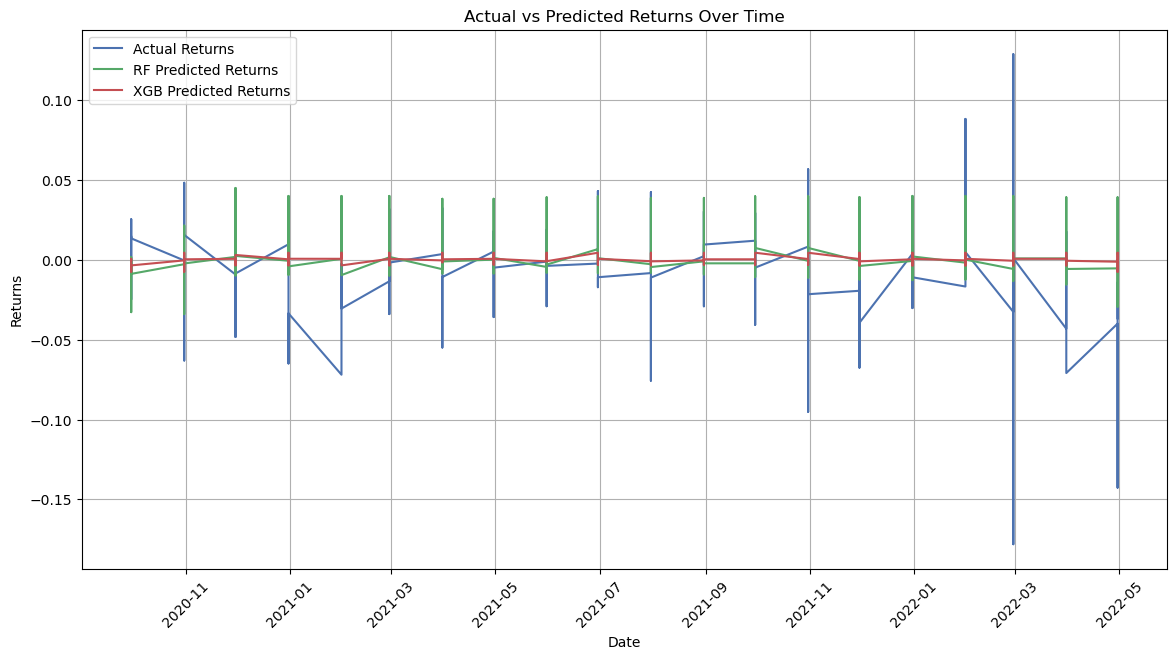

Random Forest R²: -0.4269906701082917, MSE: 0.00047932831969983643
XGBoost R²: -0.07562148437548544, MSE: 0.0003613028799267617


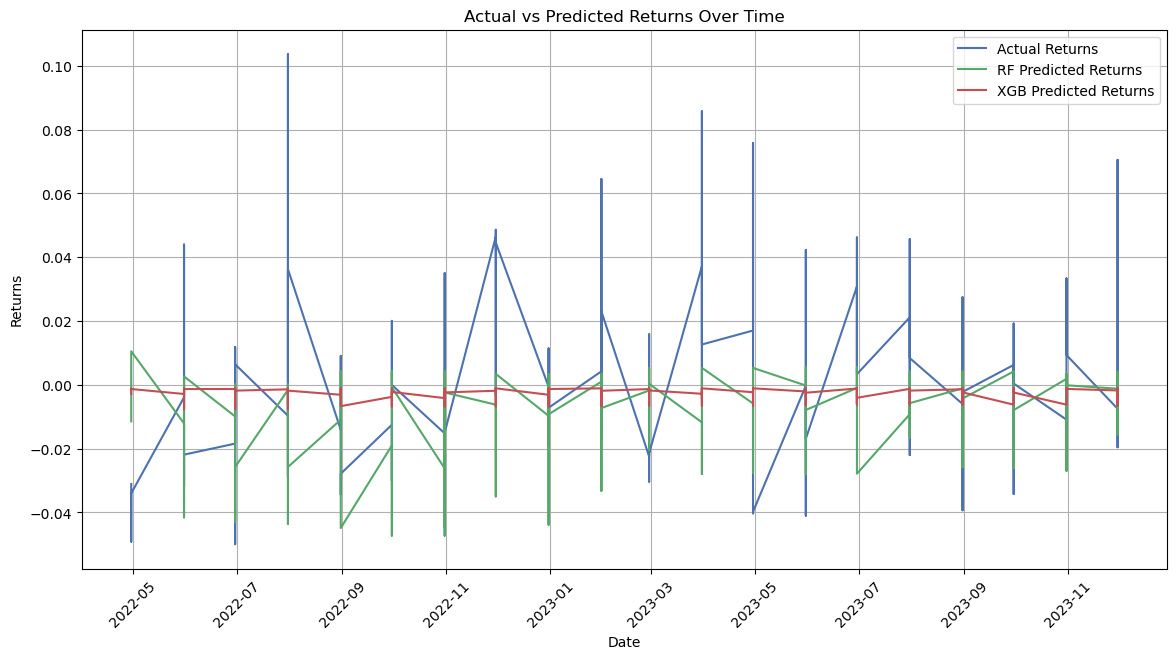

Average Random Forest MSE: 0.0004356730784084704
Average XGBoost MSE: 0.0003905723631698732
Using XGBoost predictions for portfolio optimization.


In [54]:
# Split the data using TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
rf_mse_list = []
xgb_mse_list = []
rf_predictions_all = np.zeros(len(target))
xgb_predictions_all = np.zeros(len(target))

# Define hyperparameter grids
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

xgb_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2]
}

for train_index, test_index in tscv.split(features):
    X_train, X_test = features.iloc[train_index], features.iloc[test_index]
    y_train, y_test = target.iloc[train_index], target.iloc[test_index]

    # Hyperparameter optimization for Random Forest
    rf = RandomForestRegressor(random_state=42)
    rf_grid_search = GridSearchCV(estimator=rf, param_grid=rf_param_grid, cv=3, scoring='neg_mean_squared_error')
    rf_grid_search.fit(X_train, y_train)
    best_rf = rf_grid_search.best_estimator_
    rf_predictions = best_rf.predict(X_test)
    rf_predictions_all[test_index] = rf_predictions

    # Hyperparameter optimization for XGBoost
    xgb = XGBRegressor(random_state=42)
    xgb_grid_search = GridSearchCV(estimator=xgb, param_grid=xgb_param_grid, cv=3, scoring='neg_mean_squared_error')
    xgb_grid_search.fit(X_train, y_train)
    best_xgb = xgb_grid_search.best_estimator_
    xgb_predictions = best_xgb.predict(X_test)
    xgb_predictions_all[test_index] = xgb_predictions

    # Compute R² and MSE
    rf_r2 = r2_score(y_test, rf_predictions)
    rf_mse = mean_squared_error(y_test, rf_predictions)
    xgb_r2 = r2_score(y_test, xgb_predictions)
    xgb_mse = mean_squared_error(y_test, xgb_predictions)

    rf_mse_list.append(rf_mse)
    xgb_mse_list.append(xgb_mse)

    print(f"Random Forest R²: {rf_r2}, MSE: {rf_mse}")
    print(f"XGBoost R²: {xgb_r2}, MSE: {xgb_mse}")

    # Visualize the Predictions
    plt.figure(figsize=(14, 7))
    plt.plot(merged_data['date'].iloc[test_index], y_test, label='Actual Returns')
    plt.plot(merged_data['date'].iloc[test_index], rf_predictions, label='RF Predicted Returns')
    plt.plot(merged_data['date'].iloc[test_index], xgb_predictions, label='XGB Predicted Returns')
    plt.legend()
    plt.title('Actual vs Predicted Returns Over Time')
    plt.xlabel('Date')
    plt.ylabel('Returns')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.show()

# Calculate average MSE for both models
avg_rf_mse = np.mean(rf_mse_list)
avg_xgb_mse = np.mean(xgb_mse_list)

print(f"Average Random Forest MSE: {avg_rf_mse}")
print(f"Average XGBoost MSE: {avg_xgb_mse}")

# Choose the model with the lower average MSE
if avg_rf_mse < avg_xgb_mse:
    predicted_returns = rf_predictions_all
    print("Random Forest Performs better.")
else:
    predicted_returns = xgb_predictions_all
    print("XGBoost performs better.")

# Convert predicted returns to a DataFrame
predicted_returns_df = pd.DataFrame(predicted_returns, index=merged_data['date'], columns=['Predicted_RET'])

# Prescriptive Analysis

We make use of the PyPortfolio Optimization library for our Portfolio Optimization. The library implements best practices for a wide variety of portfolio optimization strategies including Mean Variance and Black-Litterman. in our case. MVO is sufficient. We find that we end up taking short positions in the larger companies for which Buffet already has a substantial position, indicating a need to reduce some of his shares in those companies.

In [55]:
# Black-Litterman Model for Portfolio Optimization
print("Pivoting price data...")
price_data = merged_data.pivot(index='date', columns='TICKER', values='PRC')

# Check if the price data is monthly
frequency = pd.infer_freq(price_data.index)
print(f"The inferred frequency of the price data is: {frequency}")

# Fill missing values in price data
price_data.replace([np.inf, -np.inf], np.nan, inplace=True)
price_data.ffill(inplace=True)
price_data.bfill(inplace=True)
print("Cleaned price data:")
print(price_data)

print("Calculating historical returns and covariance matrix...")
mu = expected_returns.mean_historical_return(price_data, frequency=12)  # Specify monthly frequency
S = risk_models.CovarianceShrinkage(price_data, frequency=12).ledoit_wolf()  # Specify monthly frequency
print("Historical returns calculated:")
print(mu)
print("Covariance matrix calculated:")
print(S)

ef = EfficientFrontier(mu, S, weight_bounds=(-1,1))
weights = ef.max_sharpe()

cleaned_weights = ef.clean_weights()

allottedShares = pd.DataFrame(list(cleaned_weights.items()), columns=['TICKER', 'Share'])
print("Alloted Shares:")
print(allottedShares)


Pivoting price data...
The inferred frequency of the price data is: ME
Cleaned price data:


TICKER           AAPL   ALLY       AMZN        AXP    BAC    BYI      C  \
date                                                                      
2014-01-31  500.60001  24.60  358.69000   85.02000  16.75  73.32  47.43   
2014-02-28  526.23999  24.60  362.10001   91.28000  16.53  67.75  48.63   
2014-03-31  536.73999  24.60  336.36499   90.03000  17.20  66.27  47.60   
2014-04-30  590.09003  24.60  304.13000   87.43000  15.14  65.11  47.91   
2014-05-31  633.00000  24.60  312.54999   91.50000  15.14  59.00  47.57   
...               ...    ...        ...        ...    ...    ...    ...   
2023-07-31  196.45000  30.54  133.67999  168.88000  32.00  83.27  47.66   
2023-08-31  187.87000  27.69  138.00999  157.99001  28.67  83.27  41.29   
2023-09-30  171.21001  26.68  127.12000  149.19000  27.38  83.27  41.13   
2023-10-31  170.77000  24.19  133.09000  146.03000  26.34  83.27  39.49   
2023-11-30  189.95000  29.22  146.09000  170.77000  30.49  83.27  46.10   

TICKER          CB    CB

# Assessment

We achieve a sharpe ratio consistent with actual reports of Buffet's performance in recent times and visualized the Efficient Frontier of the portfolio.

In [56]:
# Calculate the portfolio performance
ef.portfolio_performance(verbose=True)

Expected annual return: 33.3%
Annual volatility: 35.9%
Sharpe Ratio: 0.87


(0.33313973156824445, 0.35906438107894195, 0.8720991222445961)

/home/onlyartist9/miniconda3/lib/python3.9/site-packages/cvxpy/reductions/solvers/solving_chain.py:356: FutureWarning: 
    You specified your problem should be solved by ECOS. Starting in
    CXVPY 1.6.0, ECOS will no longer be installed by default with CVXPY.
    Please either add ECOS as an explicit install dependency to your project
    or switch to our new default solver, Clarabel, by either not specifying a
    solver argument or specifying ``solver=cp.CLARABEL``. To suppress this
    warning while continuing to use ECOS, you can filter this warning using
    Python's ``warnings`` module until you are using 1.6.0.
    
  warnings.warn(ECOS_DEP_DEPRECATION_MSG, FutureWarning)


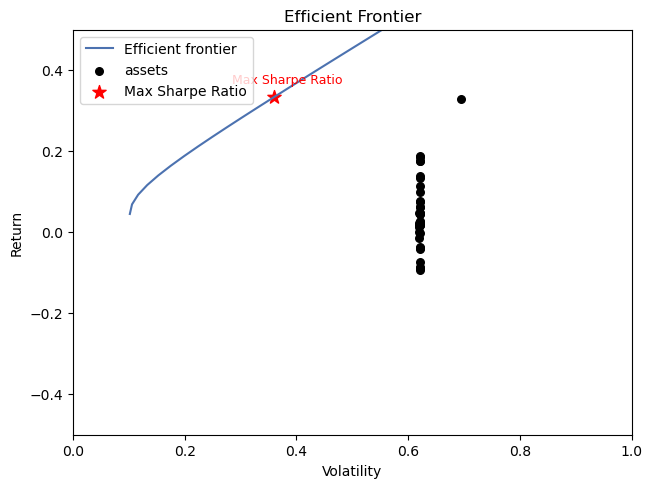

In [63]:
fig, ax = plt.subplots()

# Plot the Efficient Frontier
ef_plot = EfficientFrontier(mu, S, weight_bounds=(-1, 1), solver="ECOS")
plotting.plot_efficient_frontier(ef_plot, ax=ax, show_assets=True)

# Create a new instance for the maximum Sharpe ratio portfolio
ef_max_sharpe = EfficientFrontier(mu, S, weight_bounds=(-1, 1), solver="ECOS")
max_sharpe = ef_max_sharpe.max_sharpe()
ret, vol, _ = ef_max_sharpe.portfolio_performance()
ax.scatter(vol, ret, marker='*', color='r', s=100, label='Max Sharpe Ratio')

# Add a label for the Max Sharpe ratio
ax.annotate('Max Sharpe Ratio', (vol, ret), textcoords="offset points", xytext=(10,10), ha='center', fontsize=9, color='r')

# Set axis limits to focus on the relevant range of values
ax.set_xlim(0, 1)  # Adjust the x-axis (volatility) range as needed
ax.set_ylim(-0.5, 0.5)  # Adjust the y-axis (return) range as needed

ax.set_title("Efficient Frontier")
ax.legend()
plt.show()


# Conclusion.

Making use of a bit of knowledge from Gu et al we find that Buffet actually has quite a great portfolio but perhaps needs to reduce his shares in some already large companies. Companies that could require reduced exposure include Apple.

In tandem with our portfolio we find that Buffet [reduced](https://www.cnbc.com/2024/08/03/warren-buffetts-berkshire-hathaway-sold-nearly-half-its-stake-in-apple.html) his number of shares in Apple by nearly half, far greater than our estimated short position of 12%.